# Fourier Ptychography
#### Chengyu  Wang, University of Arizona

This notebook implements the Fourier Ptyhography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.metrics import structural_similarity as ssim

In [2]:
## PUPIL
def get_pupil(apD):
    # apD: diameter of the aperture
    r = apD/2
    y,x = np.ogrid[-r+0.5: r:1, -r+0.5: r]
    disk = x**2+y**2 <= r**2 
    disk = disk.astype(float)
    return disk

In [3]:
input_dim = 512     # image dimension (512,512)
pad = 8 + 25       # Adding padding to the fourier space
measure_dim = 128     # diameter of the aperture
spacing = int(np.round(128 * (1-0.61)))   # spacing between apertures, ensure 61% overlap

#### Each circle represents an aperture location.
#### The square represents the Fourier transform of the image

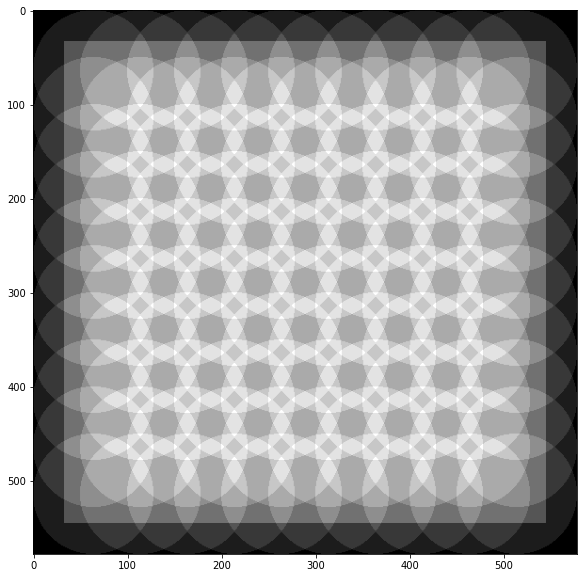

In [4]:
mesh = np.arange(0,input_dim + 2  * pad - measure_dim + 1,spacing)
xlocations,ylocations = np.meshgrid(mesh,mesh);
xlocations = xlocations.astype(int).flatten()
ylocations = ylocations.astype(int).flatten()
num_frame = len(mesh)**2

dim_measure = np.ones([num_frame],'int') * measure_dim
cam_locations = np.concatenate([xlocations.reshape([-1,1]),ylocations.reshape([-1,1])],1)
  
## pattern
pattern = np.zeros([input_dim + 2  * pad,input_dim + 2  * pad])
pattern[pad:input_dim + pad,pad:input_dim + pad] = 2
for i in range(len(dim_measure)):
    pattern[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
            cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]] += get_pupil(dim_measure[i])
plt.figure(figsize = (10,10))
plt.imshow(pattern,cmap='gray')
plt.show()

In [5]:
def get_meaurement(im,photons,is_noisy):
    X = np.zeros([num_frame,measure_dim,measure_dim])
    x = np.pad(np.fft.fftshift(np.fft.fft2(im.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    for i in range(num_frame):
        X[i,:,:] = np.abs(np.fft.ifft2(x[cam_locations[i,0]:cam_locations[i,0]+dim_measure[i],
                                        cam_locations[i,1]:cam_locations[i,1]+dim_measure[i]]* get_pupil(dim_measure[i]))) *np.sqrt(photons) * dim_measure[i]
    if is_noisy:
        X = np.sqrt(np.random.poisson(np.power(X,2)))
    return X/np.sqrt(photons)

In [6]:
def reconstruction(measure):
    ## AP
    initial_image = cv2.resize(measure[45,:,:],(512,512))
    xest = np.pad(np.fft.fftshift(np.fft.fft2(initial_image.astype('complex128')))/input_dim,((pad,pad),(pad,pad)))
    order = list(range(num_frame))
    for iter_ in range(100):
        xest[0:pad,:] = 0
        xest[pad+512:pad*2 + 512,:] = 0
        xest[:,0:pad] = 0
        xest[:pad+512:pad*2 + 512] = 0
        random.shuffle(order)
        for im_idx in order:
            im = np.fft.ifft2(xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                   cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]]* get_pupil(dim_measure[im_idx]))
            im = measure[im_idx,:,:].astype('complex128') * np.exp(1j * np.angle(im))
            xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                 cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] = xest[cam_locations[im_idx,0]:cam_locations[im_idx,0]+dim_measure[im_idx],
                                                                                             cam_locations[im_idx,1]:cam_locations[im_idx,1]+dim_measure[im_idx]] * (1-get_pupil(dim_measure[im_idx])) + np.fft.fft2(im) / dim_measure[im_idx] * get_pupil(dim_measure[im_idx])
    estimate = np.fft.ifft2(np.fft.ifftshift(xest[pad:pad + input_dim,pad:pad + input_dim])) * input_dim
    return estimate   

In [7]:
def mse_loss(xest,y):
    error = abs(xest) - abs(y)
    return np.mean(error**2)

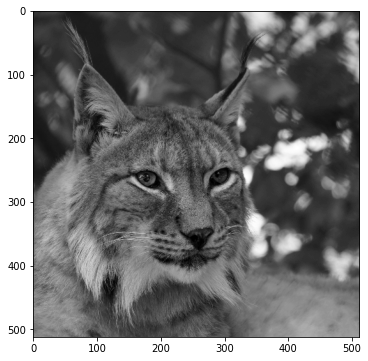

In [8]:
im = cv2.imread('data_sample/sample_fp.png',0)/255
plt.figure(figsize= (6,6))
plt.imshow(im,cmap = 'gray')

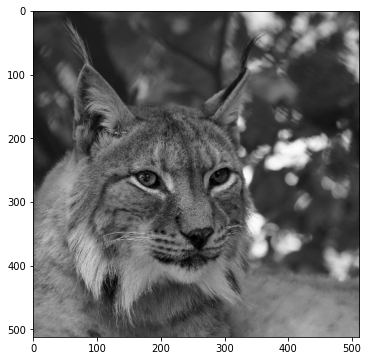

PSNR: 54.85313727169958 ssim: 0.9994583981727613


In [9]:
# measurement
measurement = get_meaurement(im,photons = 1e5,is_noisy = True)

# reconstruction
estimate = reconstruction(measurement)
plt.figure(figsize= (6,6))
plt.imshow(abs(estimate),cmap='gray')
plt.show()

# evaluation
print("PSNR:",10*np.log10(1/mse_loss(estimate,im)), "ssim:",ssim(abs(estimate),im))